# Special holiday assignment:<br/>*Explorative Cooking*

## Organization

During the winter holidays, we want you to explore a fairly large dataset and try various approaches to classify and cluster the data. There is no *one way to go* and you will have to decide which approaches to use on your own. In the exercises on January 15th & 16th (**January 8th & 9th will be no exercise** as I am gone for a conference), we will have time to discuss your results and you can test your results against your fellow students.

Your solutions do not need to be perfect, as there is no *one true answer*. Please take notes on everything you attempt and be ready to answer these questions:
1. What did you do?
1. Why did you do that?
1. Did it work?
1. If it did (not) work, why (not)? (assumptions suffice)

In the next exercise, we will test your code on a separate (smaller) test set, that is not provided in the moodle.<br/>
Please remember to bring your code to the exercise or mail it to me in advance, so we can decide whose approaches perform best on the test set. 😉

## The Data

For this special assignment, you are provided with a large database of recipes that you can download from the moodle.

**The recipes consist of:**
1. Recipe names (column `Titel`)
1. 2610 possible ingredients (columns `Aal`, ..., `Krabbenfleisch`, not alphabetically ordered)
1. A classification of whether any form of fish or seafood is included (column `Mit Fisch`)
1. A classification of whether any form of meat is included (column `Mit Fleisch`)

The data thus has 2613 columns and 28000 rows. The title is always a string, every other entry is `True` (e.g. ingredient is included) and `False` otherwise.

Beware: The data may contain noise! Recipes can in very few cases contain unintuitive ingredients, but that shouldn't hinder your work.

Additionally you are given a list of ingredient descriptions.

**The ingredient descriptions consist of:**
1. Ingredient name (column `name`)
1. Some rough categories (column `categories`, not nearly complete)
1. A classification as `Veggie` (not seafood or meat), `Fisch` (seafoods) and `Fleisch` (meat) (column `class`)

To ease your work, animal products such as egg and milk (that did not require an animal to die) are classified as `Veggie`. These are hence ingredients vegetarians but not vegans would eat. We did not split by vegan, as milk and eggs are used very differently (e.g. in cakes and puddings) than meats and organs and would make classification a lot harder. In addition, these ingredients are fairly easy to *veganize* (using almond/soy milk, chia seeds, ...) and differentiating between e.g. soy milk and milk would add a lot of non informative features.

## Code frame

In the following cells, you can find the necessary code for importing the data and some functions, that may help you debug your code.

In [1]:
# Imports
import numpy as np
import pandas as pd

In [2]:
# Special column names
KEY_TITLE = 'Titel'
KEY_MEAT = 'Mit Fleisch'
KEY_FISH = 'Mit Fisch'

In [8]:
# Read the ingredients table
ingredients = pd.read_csv("ingredients.csv")
# Split ingredients by class
veggies = ingredients.loc[ingredients['class'] == 'Veggie']
meats = ingredients.loc[ingredients['class'] == 'Fleisch']
fishes = ingredients.loc[ingredients['class'] == 'Fisch']

In [4]:
# Read the recipes table
recipes = pd.read_csv("recipes_train.gz")
recipes = recipes.rename(columns={recipes.columns[0]:KEY_TITLE})
recipe_index = {name:i for i,name in enumerate(recipes[KEY_TITLE])}

In [5]:
# Helping functions
def recipe_by_name(name):
    global recipes, recipe_index
    return recipes.iloc[recipe_index[name]]
def recipe_by_index(idx):
    global recipes
    return recipes.iloc[idx]
def fields_of_recipe(recipe):
    return {col: recipe[col] for col in recipe.keys() if recipe[col] != False}
def ingredients_of_recipe(recipe):
    return [col for col in ingredients['name'] if recipe[col] != False]
def classification_of_recipe(recipe):
    return {name:recipe[name] for name in [KEY_TITLE,KEY_MEAT,KEY_FISH]}
def recipes_with_flag(recipes, col):
    return recipes.loc[recipes[col] != False]
def recipes_without_flag(recipes, col):
    return recipes.loc[recipes[col] == False]

In [6]:
# Example 1:
# Retain only recipes with meat
meat_recipes = recipes_with_flag(recipes,KEY_MEAT)
# Remove all recipes with fish
meat_no_fish_recipes = recipes_without_flag(meat_recipes,KEY_FISH)
# Print ingredient list of first 5 recipes
for i in meat_no_fish_recipes.index[:5]:
    print(ingredients_of_recipe(meat_no_fish_recipes.loc[i]))

['Ananas', 'Backpulver', 'Gelatine', 'Maronenkonfitüre', 'Mehl', 'Sahne', 'Zucker', 'Eigelb']
['Aprikose', 'Curryblätter', 'Schweinefleisch', 'Wasser', 'Zucker', 'Zwiebel', 'Fleisch']
['Aubergine', 'Butter', 'Joghurt', 'Kartoffel', 'Knoblauch', 'Lammhackfleisch', 'Paprika', 'Rosmarin', 'Salbei', 'Salz', 'Tomatenmark', 'Zwiebel', 'Eier', 'Fleischbrühe']
['Bauchspeck', 'Kartoffel', 'Majoran', 'Mehl', 'Pfeffer', 'Salz', 'Schweineschwanz', 'Zwiebel']
['Kartoffel', 'Kümmel', 'Majoran', 'Mettwurst', 'Petersilie', 'Saure Sahne', 'Zwiebel', 'Eier']


In [7]:
# Example 2:
# Get recipe by name
r = recipe_by_name('Insalata mista')
# Print info about recipe
print(ingredients_of_recipe(r))
print(classification_of_recipe(r))

['Bohne', 'Gurke', 'Kirschtomate', 'Olivenöl', 'Pfeffer', 'Rotweinessig', 'Salz']
{'Titel': 'Insalata mista', 'Mit Fleisch': False, 'Mit Fisch': False}


## Task 1: Classification

The first task is to identify recipes with fish and meat **without** looking at the fish and meat ingredients.<br/>
This answers the question: "*Would the authors of this collection add fish or meat to this recipe based on its other ingredients?*"

**Example:**<br/>
Assuming a recipe for potato salad with pork. The ingredients might be:
$$\{\text{Speck},\text{Kartoffel},\text{Zwiebel},\text{Essig},\text{Salz},\text{Pfeffer}\}$$
$$\scriptsize\left(\{\text{Bacon},\text{Potato},\text{Onion},\text{Vinegar},\text{Salt},\text{Pepper}\}\right)$$
The classification would obviously be
$$(\text{Mit Fisch}=False, \text{Mit Fleisch}=True)$$
$$\scriptsize\left(\text{With fish}=False, \text{With meat}=True\right)$$
as $\text{Speck}$ $\scriptsize(\text{Bacon})$ is meat.<br/>
Your model however will not be informed about any fish or meat ingredients during classification!<br/>
Your model shall be able to answer the question
$$\text{Does a recipe with }\{\text{Kartoffel},\text{Zwiebel},\text{Essig},\text{Salz},\text{Pfeffer}\}\text{ also contain meat/fish?}$$
$$\scriptsize\left(\text{Does a recipe with }\{\text{Potato},\text{Onion},\text{Vinegar},\text{Salt},\text{Pepper}\}\text{ also contain meat/fish?}\right)$$

You can use the following code frame to prepare the data:

In [8]:
import numpy as np
def generate_split(X,y,p):
    train_ids = np.random.permutation(len(X)) < p * len(X)
    test_ids = ~train_ids
    X_train, X_test = X[train_ids], X[test_ids]
    y_train, y_test = y[train_ids], y[test_ids]
    return X_train, y_train, X_test, y_test

At first, try to get the best test score for the two class problem
1. **no fish** (label = 0)
1. **fish** (label = 1)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.metrics import mean_squared_error

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
# 2 Classes: No fish, fish
features = np.concatenate([l['name'] for l in [veggies,meats]])
X = recipes[features]
y = recipes[KEY_FISH]*1
X_train, y_train, X_test, y_test = generate_split(X,y,.8)

MSE: 0.0834


Text(0,0.5,'Deviance')

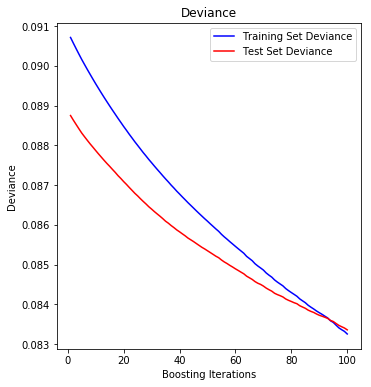

In [13]:
# TODO
# #############################################################################
# Fit regression model
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)
print("accuracy score: ", clf.score(X_test, y_test)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

Now try to get the best test score for the two class problem
1. **no meat** (label = 0)
1. **meat** (label = 1)

In [14]:
# 2 Classes: No meat, meat
features = np.concatenate([l['name'] for l in [veggies,fishes]])
X = recipes[features]
y = recipes[KEY_MEAT]*1
X_train, y_train, X_test, y_test = generate_split(X,y,.8)

MSE: 0.2158
accuracy score:  0.11400640956338869


Text(0,0.5,'Deviance')

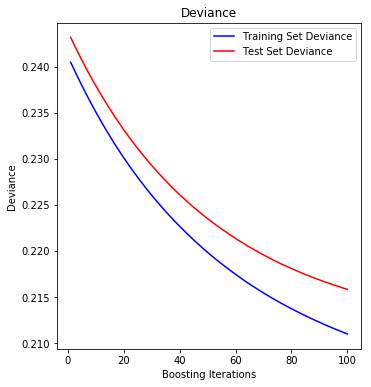

In [17]:
# TODO

# #############################################################################
# Fit regression model
params = {'n_estimators': 100, 'max_depth': 4,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)
print("accuracy score: ", clf.score(X_test, y_test))

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

Now try to get the best test score for the 4 class problem
1. **no meat + no fish** (label = 0)
1. **meat + no fish** (label = 1)
1. **no meat + fish** (label = 2)
1. **meat + fish** (label = 3)

In [ ]:
# 2 Classes: No fish, fish
features = veggies['name']
X = recipes[features]
y = recipes[KEY_MEAT]*1 + recipes[KEY_FISH]*2
X_train, y_train, X_test, y_test = generate_split(X,y,.8)

In [ ]:
# TODO

# #############################################################################
# Fit regression model
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)
print("accuracy score: ", clf.score(X_test, y_test))

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

## Task 2: Clustering

The second task is to identify sweet recipes such as cookies, cakes, pancakes, fruit bowls and so on. You may use any clustering algorithm you deem appropriate. The sweet recipes do not need to end up in only one cluster, but neither should they be split up among more than at most 10 clusters. It should be reasonable effort to combine them into one list.<br/>
You also do not need to compute your result in one step. Data preparation, iterative refinements and the like are fine as well.

Do not worry if you end up with a solution that does not contain *all* and *only* sweet recipes!<br/>
This task is far from easy and an *as good as possible* solution is just fine!<br/>
Remember to take notes on what worked and what did not.

*Hint 1:* The data consists of sparse (binary) vectors. Angle based measures usually work quite well on those.

*Hint 2:* You don't need to work on the entire table at once! Feel free to reduce the working set and remove columns, that are all $0$ or $False$.

*Hint 3:* The ingredients are not independent! E.g. different kinds of meat and vegetables can be interchangeable. Having the same recipe two times with different kinds of potatoes or meats should not be equally dissimilar than having one of these recipes use fruits or fish instead. You can *smooth* the vectors by using the interaction of ingredients.

In [5]:
from sklearn.cluster import KMeans
recipes_ar = recipes.values
recipes_ar = np.delete(recipes_ar,0,1)

In [ ]:
km = KMeans(n_clusters=8).fit(recipes_ar)

In [ ]:
label6 = [i for i in range(len(km.labels_)) if km.labels_[i] == 6]
print(recipes.loc[label6[10]])

In [20]:
recipes.loc[1]['Zucker']

True

In [21]:
#Zucker Cluster, alle mit Zucker in ein Cluster
zucker_label = np.zeros(len(recipes))
for k in range(len(recipes)):
    if (recipes.loc[k]["Zucker"]):
        zucker_label[k] = 1

In [28]:
np.mean(zucker_label)*100

33.542857142857144

In [12]:
arr = np.array([['a',1,1],['b',0,4],['c',3,9]])
arr

array([['a', '1', '1'],
       ['b', '0', '4'],
       ['c', '3', '9']], dtype='<U1')

In [15]:
np.delete(arr,0,1)

array([['1', '1'],
       ['0', '4'],
       ['3', '9']], dtype='<U1')